#  Сегментация птиц на изображениях

## 1. Импорт необходимых для задачи библиотек

In [1]:
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import os
from torchvision.io import read_image
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import torch
from torchvision import transforms as T
from tqdm.notebook import tqdm
import random
from skimage.io import imread
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torchsummary import summary
import gc
import albumentations as A

torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
np.random.seed(42)
random.seed(42)        

## 2. Проверка доступа к GPU

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## 3. Дополнительные функции для обработки и преобразования датасета

In [3]:
def ToRGB(arr):
    if arr.shape[0] == 1:
        return torch.cat((arr, arr, arr), dim=0)
    else:
        return arr
    
def MyPad(img):
    height, width = img.size[0], img.size[1]
    if height > width:
        tf = T.Pad(padding=(0, (height - width) // 2))
    else:
        tf = T.Pad(padding=((width - height) // 2, 0))
    return tf(img)

def check(label):
    if label.shape[0] == 2:
        return label[:-1, :, :]
    return label

class BirdsSegmentDataset(Dataset):
    def __init__(self, img_folder, label_folder, image_transform=None, target_transform=None, general_transform=None):
        super(BirdsSegmentDataset, self).__init__()
        self.images = img_folder
        self.labels = label_folder
        self.samples = self.get_samples(img_folder)
        self.image_transform = image_transform
        self.target_transform = target_transform
        self.general_transform = general_transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index):
        sample = self.samples[index]
        img_file = os.path.join(self.images, sample) + '.jpg'
        image = Image.open(img_file)
        label_file = os.path.join(self.labels, sample) + '.png'
        label = Image.open(label_file)
        if self.image_transform is not None:
            image = self.image_transform(image)
        if self.target_transform is not None:
            label = (self.target_transform(label) > 0.5).float()
        if self.general_transform is not None:
            augmented_data = self.general_transform(image=image.numpy().transpose(1, 2, 0), mask=label.numpy().transpose(1, 2, 0))
            image = torch.FloatTensor(augmented_data['image'].transpose(2, 0, 1))
            label = torch.FloatTensor(augmented_data['mask'].transpose(2, 0, 1))
        return image, label

    @staticmethod
    def get_samples(img_folder):
        samples = []
        for folder in os.listdir(img_folder):
            path_fold = os.path.join(img_folder, folder)
            for file in os.listdir(path_fold):
                samples.append(os.path.join(folder, file)[:-4])
        return samples
    
image_transform = T.Compose([
    T.Lambda(MyPad),
    T.Resize((256, 256), interpolation=T.InterpolationMode.BICUBIC),
    T.ToTensor(),
    T.Lambda(ToRGB),
])

target_transform = T.Compose([
    T.Lambda(MyPad),
    T.Resize((256, 256), interpolation=T.InterpolationMode.BICUBIC),
    T.ToTensor(),
    T.Lambda(check)
])
general_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=15)
])

## 4. Визуализация обучающей выборки
Для того, чтобы сделать это, выполните следующее:
 * Скачайте архив с данными, ссылка на который указана в README.md и разархивируйте его
 * Поместите разархивированную папку с датасетом в одну директорию с данным ноутбуком
 * В первый двух строках следующей ячейки укажите правильный путь до данных:
   * img_folder = '[Разархивированная папка]/00_test_val_input/train/images'
   * label_folder = '[Разархивированная папка]/00_test_val_input/train/gt'

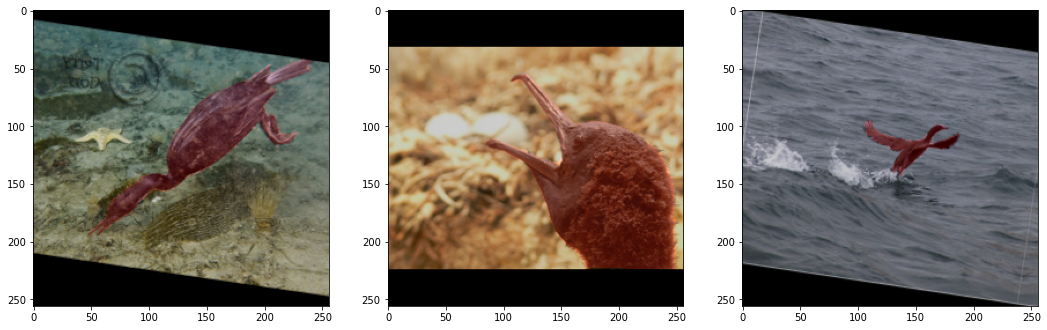

In [4]:
img_folder = 'tests/00_test_val_input/train/images'
label_folder = 'tests/00_test_val_input/train/gt'

def blend(image, mask):
    image = np.array(image)
    mask = np.array(mask)
    min_in = image.min()
    max_in = image.max()
    image = ((image - min_in) / (max_in - min_in + 1e-8) * 255).astype(np.uint8)
    zeros = np.zeros_like(mask)
    mask = np.vstack((mask * 255, zeros, zeros)).astype(np.uint8)
    image = image.transpose(1, 2, 0)
    mask = mask.transpose(1, 2, 0)
    return Image.blend(
        Image.fromarray(image),
        Image.fromarray(mask),
        alpha=.2
    )

dataset = BirdsSegmentDataset(img_folder, label_folder, image_transform, target_transform, general_transform)

slices_num = (1, 2, 10)
slices = []
for idx in slices_num:
    image, label = dataset[idx]
    slices.append(blend(
        image,
        label
    ))

figure = plt.figure(figsize=(18, 18))
for i, image in enumerate(slices):
    ax = figure.add_subplot(1, len(slices), i + 1)
    ax.imshow(image)

## 5. Архиетктура нейросети(U-Net) и дополнительные функции для реализации обучения

In [5]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.c1_1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding=1)
        self.c1_2 = nn.BatchNorm2d(8)
        self.c1_3 = nn.ReLU()
        self.c1_4 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, padding=1)
        self.c1_5 = nn.BatchNorm2d(8)
        self.c1_6 = nn.ReLU()
        self.p1 = nn.MaxPool2d(2, stride=2)

        self.c2_1 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1)
        self.c2_4 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1)
        self.c2_5 = nn.BatchNorm2d(16)
        self.c2_6 = nn.ReLU()
        self.p2 = nn.MaxPool2d(2, stride=2)

        self.c3_1 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.c3_4 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.c3_5 = nn.BatchNorm2d(32)
        self.c3_6 = nn.ReLU()
        self.p3 = nn.MaxPool2d(2, stride=2)

        self.c4_1 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.c4_4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.c4_5 = nn.BatchNorm2d(64)
        self.c4_6 = nn.ReLU()
        self.p4 = nn.MaxPool2d(2, stride=2)

        self.c5_1 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.c5_4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.c5_5 = nn.BatchNorm2d(128)
        self.c5_6 = nn.ReLU()

        self.e6_1 = nn.Upsample(scale_factor=2)
        self.e6_2 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1)
        self.c6_1 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1)
        self.c6_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.c6_3 = nn.BatchNorm2d(64)
        self.c6_4 = nn.ReLU()

        self.e7_1 = nn.Upsample(scale_factor=2)
        self.e7_2 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1)
        self.c7_1 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1)
        self.c7_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.c7_3 = nn.BatchNorm2d(32)
        self.c7_4 = nn.ReLU()

        self.e8_1 = nn.Upsample(scale_factor=2)
        self.e8_2 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1)
        self.c8_1 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1)
        self.c8_2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1)
        self.c8_3 = nn.BatchNorm2d(16)
        self.c8_4 = nn.ReLU()

        self.e9_1 = nn.Upsample(scale_factor=2)
        self.e9_2 = nn.Conv2d(in_channels=16, out_channels=8, kernel_size=3, padding=1)
        self.c9_1 = nn.Conv2d(in_channels=16, out_channels=8, kernel_size=3, padding=1)
        self.c9_2 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, padding=1)
        self.c9_3 = nn.BatchNorm2d(8)
        self.c9_4 = nn.ReLU()

        self.out_1 = nn.Conv2d(in_channels=8, out_channels=1, kernel_size=3, padding=1)
        self.out_2 = nn.Sigmoid()

    def forward(self, x):
        c1 = self.c1_6(self.c1_5(self.c1_4(self.c1_3(self.c1_2(self.c1_1(x))))))
        p1 = self.p1(c1)
        c2 = self.c2_6(self.c2_5(self.c2_4(self.c2_1(p1))))
        p2 = self.p2(c2)
        c3 = self.c3_6(self.c3_5(self.c3_4(self.c3_1(p2))))
        p3 = self.p3(c3)
        c4 = self.c4_6(self.c4_5(self.c4_4(self.c4_1(p3))))
        p4 = self.p4(c4)
        c5 = self.c5_6(self.c5_5(self.c5_4(self.c5_1(p4))))

        e6 = self.e6_2(self.e6_1(c5))
        e6 = torch.cat((e6, c4), dim=1)
        c6 = self.c6_4(self.c6_3(self.c6_2(self.c6_1(e6))))
        e7 = self.e7_2(self.e7_1(c6))
        e7 = torch.cat((e7, c3), dim=1)
        c7 = self.c7_4(self.c7_3(self.c7_2(self.c7_1(e7))))
        e8 = self.e8_2(self.e8_1(c7))
        e8 = torch.cat((e8, c2), dim=1)
        c8 = self.c8_4(self.c8_3(self.c8_2(self.c8_1(e8))))
        e9 = self.e9_2(self.e9_1(c8))
        e9 = torch.cat((e9, c1), dim=1)
        c9 = self.c9_4(self.c9_3(self.c9_2(self.c9_1(e9))))

        z = self.out_2(self.out_1(c9))
        return z
    
def get_iou(gt, pred):
    return (gt & pred).sum() / (gt | pred).sum()

def train_epoch(model, device, dataloader, loss_fn, optimizer):

    train_loss = 0.0
    metric = 0.0

    for images, labels in tqdm(dataloader):

        images, labels = images.to(device), labels.to(device)

        output = model(images)
        loss = loss_fn(output, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        output = output.cpu().detach().numpy() > 0.5
        labels = labels.cpu().detach().numpy() > 0.5

        metric += get_iou(labels, output)
        train_loss += loss.item()

    return train_loss / len(dataloader), metric / len(dataloader)

def valid_epoch(model, device, dataloader, loss_fn):

    val_loss = 0.0
    metric = 0.0

    for images, labels in tqdm(dataloader):

        images, labels = images.to(device), labels.to(device)

        output = model(images)
        loss = loss_fn(output, labels)
        
        output = output.cpu().detach().numpy() > 0.5
        labels = labels.cpu().detach().numpy() > 0.5

        metric += get_iou(labels, output)
        val_loss += loss.item()

    return val_loss / len(dataloader), metric / len(dataloader)

def fit(model, trainloader, validloader, optimizer, criterion, epochs):

    val_max_DC = 0

    for epoch in range(epochs):

        model.train()
        train_loss, train_metric = train_epoch(model, device, trainloader, criterion, optimizer)

        model.eval()
        val_loss, val_metric = valid_epoch(model, device, validloader, criterion)

        print("Epoch:{}/{} \n".format(epoch + 1, epochs),
              "Training loss:{:.3f}, Training metric:{:.4f}\n".format(train_loss, train_metric),
              "Validation loss:{:.3f}, Validation metric:{:.4f}\n".format(val_loss, val_metric))
        if val_metric > val_max_DC:
            print("Vall metric increased: {} --> {}".format(val_max_DC, val_metric))
            val_max_DC = val_metric
            torch.save(model.state_dict(), 'segmentation_model.pth')


## 6. Создаем модель для обучения
!Можно сразу перейти к пунтку 8, где приводятся результаты моей лучшей модели

In [6]:
model = UNet()
model.to(device)
summary(model, input_size = (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 256, 256]             224
       BatchNorm2d-2          [-1, 8, 256, 256]              16
              ReLU-3          [-1, 8, 256, 256]               0
            Conv2d-4          [-1, 8, 256, 256]             584
       BatchNorm2d-5          [-1, 8, 256, 256]              16
              ReLU-6          [-1, 8, 256, 256]               0
         MaxPool2d-7          [-1, 8, 128, 128]               0
            Conv2d-8         [-1, 16, 128, 128]           1,168
            Conv2d-9         [-1, 16, 128, 128]           2,320
      BatchNorm2d-10         [-1, 16, 128, 128]              32
             ReLU-11         [-1, 16, 128, 128]               0
        MaxPool2d-12           [-1, 16, 64, 64]               0
           Conv2d-13           [-1, 32, 64, 64]           4,640
           Conv2d-14           [-1, 32,

/home/se_tru/.local/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


###  7. Обучение модели
Если Вы еще не скачали данные, то вернитесь к пунтку 4

In [15]:
VAL_SPLIT = 0.22

train_set = BirdsSegmentDataset(img_folder, label_folder, image_transform, target_transform, general_transform)

indices = list(range(len(train_set)))
np.random.shuffle(indices)
split = int(round(VAL_SPLIT * len(indices)))

train_sampler = SubsetRandomSampler(indices[split:])
val_sampler = SubsetRandomSampler(indices[:split])

optimizer = torch.optim.Adam(model.parameters(), lr=0.0007)
criterion = nn.BCELoss()

train_loader = DataLoader(train_set, sampler=train_sampler, batch_size=26, num_workers=8)
val_loader = DataLoader(train_set, sampler=val_sampler, batch_size=26, num_workers=8)

fit(model, train_loader, val_loader, optimizer, criterion, epochs=30)

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch:1/16 
 Training loss:0.041, Training metric:0.8444
 Validation loss:0.050, Validation metric:0.8185

Vall metric increased: 0 --> 0.8185349687348841


  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch:2/16 
 Training loss:0.041, Training metric:0.8471
 Validation loss:0.051, Validation metric:0.8162



  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch:3/16 
 Training loss:0.041, Training metric:0.8472
 Validation loss:0.049, Validation metric:0.8243

Vall metric increased: 0.8185349687348841 --> 0.8242852545095923


  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch:4/16 
 Training loss:0.038, Training metric:0.8545
 Validation loss:0.048, Validation metric:0.8294

Vall metric increased: 0.8242852545095923 --> 0.8293904121576517


  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch:5/16 
 Training loss:0.039, Training metric:0.8516
 Validation loss:0.049, Validation metric:0.8250



  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch:6/16 
 Training loss:0.039, Training metric:0.8524
 Validation loss:0.046, Validation metric:0.8339

Vall metric increased: 0.8293904121576517 --> 0.8339232958358106


  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch:7/16 
 Training loss:0.037, Training metric:0.8575
 Validation loss:0.050, Validation metric:0.8256



  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch:8/16 
 Training loss:0.038, Training metric:0.8531
 Validation loss:0.047, Validation metric:0.8338



  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch:9/16 
 Training loss:0.037, Training metric:0.8586
 Validation loss:0.049, Validation metric:0.8263



  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch:10/16 
 Training loss:0.037, Training metric:0.8591
 Validation loss:0.053, Validation metric:0.8130



  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch:11/16 
 Training loss:0.037, Training metric:0.8574
 Validation loss:0.050, Validation metric:0.8265



  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch:12/16 
 Training loss:0.038, Training metric:0.8565
 Validation loss:0.049, Validation metric:0.8314



  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch:13/16 
 Training loss:0.035, Training metric:0.8640
 Validation loss:0.048, Validation metric:0.8316



  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch:14/16 
 Training loss:0.036, Training metric:0.8606
 Validation loss:0.048, Validation metric:0.8320



  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch:15/16 
 Training loss:0.036, Training metric:0.8614
 Validation loss:0.048, Validation metric:0.8326



  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch:16/16 
 Training loss:0.035, Training metric:0.8652
 Validation loss:0.048, Validation metric:0.8287



In [ ]:
del model
gc.collect()
torch.cuda.empty_cache()

## 8. Загружаем лучшую модель 'segmentation_model.pth'
Скачайте веса из репозитория на свой компьютер и поместите в одну директорию с ноутбуком

In [6]:
model = UNet()
model.load_state_dict(torch.load('segmentation_model.pth'))
model.to(device)

UNet(
  (c1_1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (c1_2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (c1_3): ReLU()
  (c1_4): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (c1_5): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (c1_6): ReLU()
  (p1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (c2_1): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (c2_4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (c2_5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (c2_6): ReLU()
  (p2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (c3_1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (c3_4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (c3_5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=

## 9. Вычисляем результаты лучшей модели на тестовых данных
Если Вы еще не скачали данные, то вернитесь к пункту 4. 
В первый двух строках следующей ячейки укажите правильный путь до тестовых данных:
 * img_folder = '[Разархивированная папка]/00_test_val_input/test/images'
 * label_folder = '[Разархивированная папка]/00_test_val_gt'

In [7]:
img_folder = 'tests/00_test_val_input/test/images'
label_folder = 'tests/00_test_val_gt'

test_set = BirdsSegmentDataset(img_folder, label_folder, image_transform, target_transform)

criterion = nn.BCELoss()

test_loader = DataLoader(test_set, batch_size=26, num_workers=8)
model.eval()
loss, metric = valid_epoch(model, device, test_loader, criterion)
print("Loss on test set: loss = {:.5f}\nIoU metric on test set: iou = {:.5f}".format(loss, metric))

  0%|          | 0/55 [00:00<?, ?it/s]

/home/se_tru/.local/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Loss on test set: loss = 0.04919
IoU metric on test set: iou = 0.82996


## 10. Визуализируем результаты

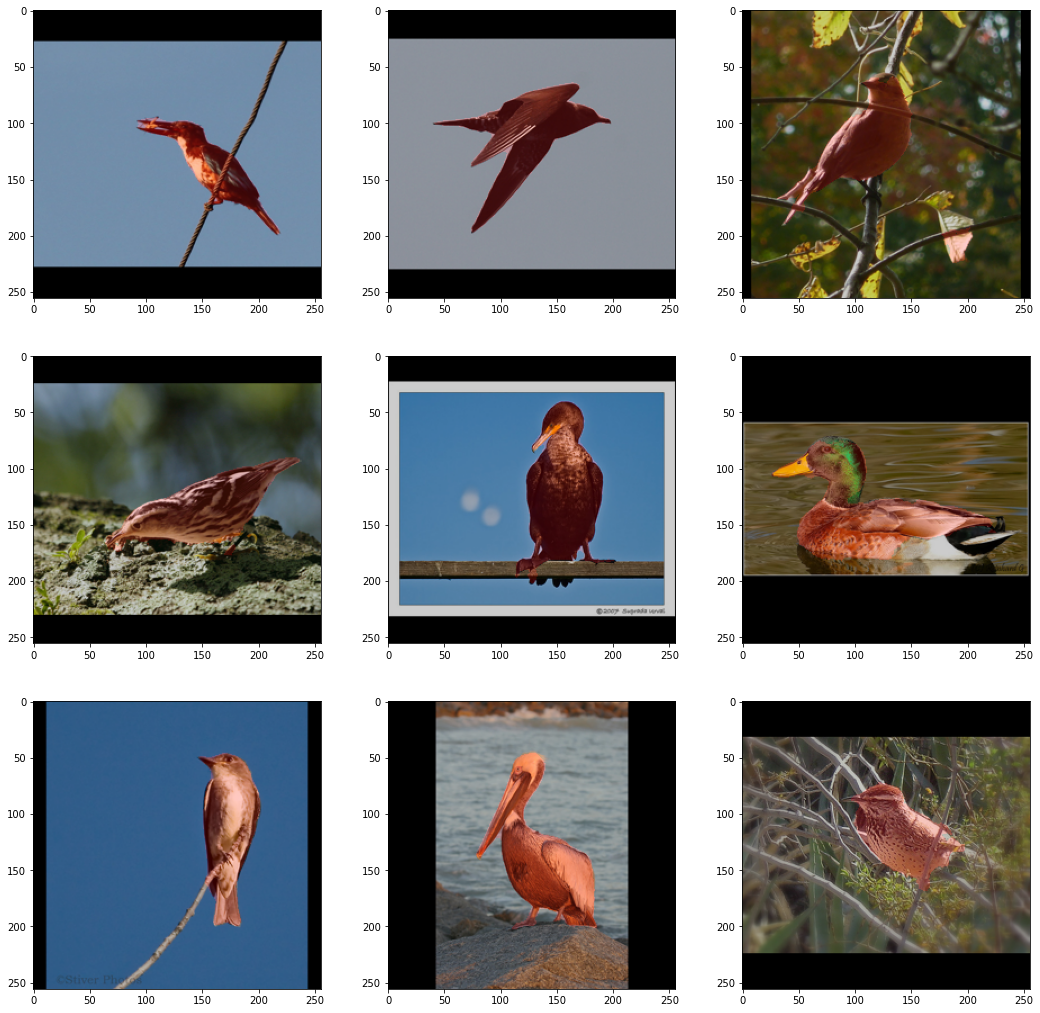

In [8]:
img_folder = 'tests/00_test_val_input/test/images'
label_folder = 'tests/00_test_val_gt'

test_loader = DataLoader(test_set, batch_size=9, shuffle=True)

dataiter = iter(test_loader)
images, labels = next(dataiter)
masks = (model(images.to(device)) > 0.5).cpu().detach()

figure = plt.figure(figsize=(18, 18))
i = 0
for image, mask in zip(images, masks):
    ax = figure.add_subplot(3, 3, i + 1)
    ax.imshow(blend(image, mask))
    i += 1